#### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [2]:
df = pd.read_csv('../../data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

#### Cleaning

In [ ]:
#for removing float/int outliers
#def remove_outlier(df):
    #for x in df:
        #q1 = df[x].quantile(0.25)
        #q3 = df[x].quantile(0.75)
        #iqr = q3-q1 #Interquartile range
        #fence_low  = q1-1.5*iqr
        #fence_high = q3+1.5*iqr
        #df_out = df.loc[(df[x] > fence_low) & (df[x] < fence_high)]
    #return df_out

In [4]:
abs(df.corr()['price']).sort_values()

id               0.016772
long             0.022036
zipcode          0.053402
yr_built         0.053953
sqft_lot15       0.082845
sqft_lot         0.089876
yr_renovated     0.129599
floors           0.256804
lat              0.306692
bedrooms         0.308787
bathrooms        0.525906
sqft_living15    0.585241
sqft_above       0.605368
sqft_living      0.701917
price            1.000000
Name: price, dtype: float64

Drops: zipcode, id, long, yr_built, sqft_lot15, sqft_lot, yr_renovated, floors, lat, and bedrooms. 

Using price as a dependent variable. Assuming our stockholder is a real estate/brokerage company, TBD, who gets a commission on each sale or purchase. 

Keeping only variables with a correlation of at least .5.

In [5]:
df2 = df.drop(['zipcode', 'id', 'long', 'yr_built', 'sqft_lot15', 'sqft_lot', 'yr_renovated', 'floors', 'lat', 'bedrooms'], axis=1)
df2
#Drop pythonically.

,date,price,bathrooms,sqft_living,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15
0,10/13/2014,221900.0,1.00,1180,NaN,NONE,Average,7 Average,1180,0.0,1340
1,12/9/2014,538000.0,2.25,2570,NO,NONE,Average,7 Average,2170,400.0,1690
2,2/25/2015,180000.0,1.00,770,NO,NONE,Average,6 Low Average,770,0.0,2720
3,12/9/2014,604000.0,3.00,1960,NO,NONE,Very Good,7 Average,1050,910.0,1360
4,2/18/2015,510000.0,2.00,1680,NO,NONE,Average,8 Good,1680,0.0,1800
...,...,...,...,...,...,...,...,...,...,...,...
21592,5/21/2014,360000.0,2.50,1530,NO,NONE,Average,8 Good,1530,0.0,1530
21593,2/23/2015,400000.0,2.50,2310,NO,NONE,Average,8 Good,2310,0.0,1830
21594,6/23/2014,402101.0,0.75,1020,NO,NONE,Average,7 Average,1020,0.0,1020
21595,1/16/2015,400000.0,2.50,1600,NaN,NONE,Average,8 Good,1600,0.0,1410


#### Date

In [6]:
df2['date'] = pd.to_datetime(df2['date'], infer_datetime_format=True)
df2['date'] = df2['date'].dt.strftime('%Y-%m')
date_price = df2.filter(['date', 'price'])
date_price.head()

,date,price
0,2014-10,221900.0
1,2014-12,538000.0
2,2015-02,180000.0
3,2014-12,604000.0
4,2015-02,510000.0


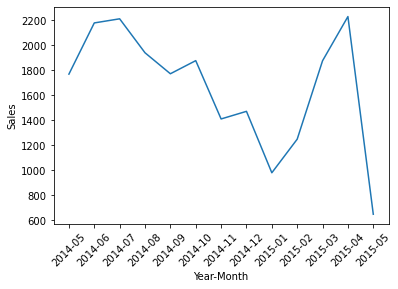

In [7]:
fig, ax = plt.subplots()
plt.xticks(rotation = 45)
ax.set_xlabel('Year-Month')
ax.set_ylabel('Sales')

ax.plot(date_price['date'].value_counts().sort_index());

In [8]:
date_avg_price = date_price.groupby(['date']).mean().sort_values(['date'])
date_avg_price.head()

,price
date,
2014-05,548166.600113
2014-06,557534.318182
2014-07,544892.161013
2014-08,536655.212481
2014-09,529723.517787


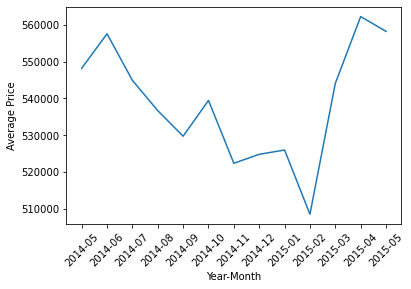

In [9]:
fig, ax = plt.subplots()
plt.xticks(rotation = 45)
ax.set_xlabel('Year-Month')
ax.set_ylabel('Average Price')

ax.plot(date_avg_price);

#### Categoricals

##### Grade and Price

In [10]:
category_df = df2.filter(['price', 'condition', 'grade'])
category_df.head()

,price,condition,grade
0,221900.0,Average,7 Average
1,538000.0,Average,7 Average
2,180000.0,Average,6 Low Average
3,604000.0,Very Good,7 Average
4,510000.0,Average,8 Good


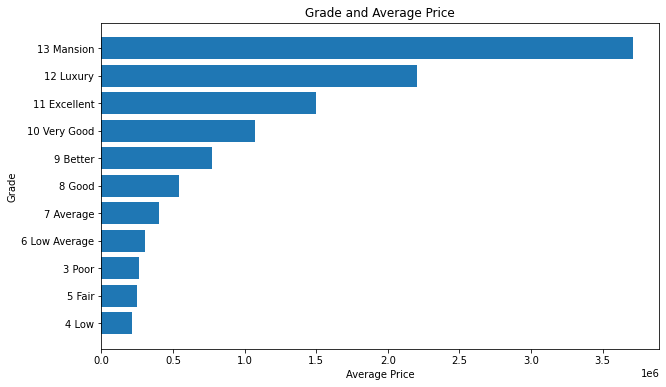

In [11]:
grade_vs_price = category_df.groupby(['grade']).mean().sort_values(['price'], ascending=False)

fig, ax = plt.subplots(figsize=(10,6))

ax.barh(y=grade_vs_price.index, width=grade_vs_price['price'])
ax.invert_yaxis()
ax.set_title('Grade and Average Price')
ax.set_ylabel('Grade')
ax.set_xlabel('Average Price');

In [12]:
category_df['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

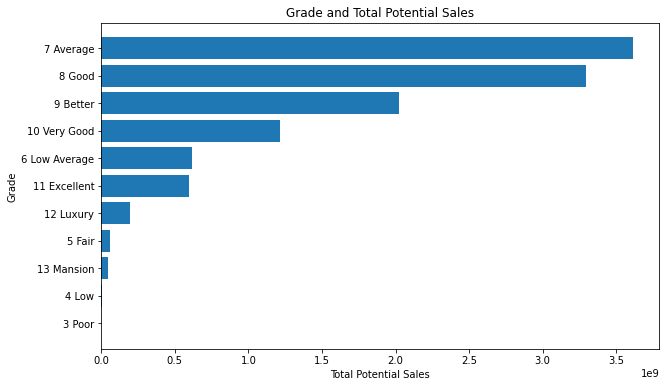

In [13]:
grade_vs_price = category_df.groupby(['grade']).sum().sort_values(['price'], ascending=False)

fig, ax = plt.subplots(figsize=(10,6))

ax.barh(y=grade_vs_price.index, width=grade_vs_price['price'])
ax.invert_yaxis()
ax.set_title('Grade and Total Potential Sales')
ax.set_ylabel('Grade')
ax.set_xlabel('Total Potential Sales');

Clearly the mansions sold for the most but there aren't many of them. They account for less of the total potential sales. 

In [14]:
grade_df = category_df.filter(['grade', 'price'])
grade_df.replace('13 Mansion', 13, inplace=True) 
grade_df.replace('12 Luxury', 12, inplace=True) 
grade_df.replace('11 Excellent', 11, inplace=True) 
grade_df.replace('10 Very Good', 10, inplace=True) 
grade_df.replace('9 Better', 9, inplace=True) 
grade_df.replace('8 Good', 8, inplace=True) 
grade_df.replace('7 Average', 7, inplace=True) 
grade_df.replace('6 Low Average', 6, inplace=True) 
grade_df.replace('5 Fair', 5, inplace=True) 
grade_df.replace('4 Low', 4, inplace=True) 
grade_df.replace('3 Poor', 3, inplace=True) 
grade_df.head()
#make function?

,grade,price
0,7,221900.0
1,7,538000.0
2,6,180000.0
3,7,604000.0
4,8,510000.0


In [15]:
stats.contingency.chi2_contingency(grade_df) 

(36879.129511544714,
 0.0,
 21596,
 array([[3.14516331e+00, 2.21903855e+05],
        [7.62535601e+00, 5.37999375e+05],
        [2.55128620e+00, 1.80003449e+05],
        ...,
        [5.69921331e+00, 4.02102301e+05],
        [5.66944929e+00, 4.00002331e+05],
        [4.60643464e+00, 3.25002394e+05]]))

In [16]:
formula = 'price ~ C(grade)'
lm = ols(formula, grade_df).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(grade),10.0,1.515506e+15,1.515506e+14,2338.238311,0.0
Residual,21586.0,1.399076e+15,6.481403e+10,NaN,NaN


#### Regression Analysis 

In [17]:
formula = 'price ~ sqft_living'
model = ols(formula=formula, data=df2).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:27:34   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
formula = 'price ~ bathrooms + sqft_living + sqft_above + sqft_living15'
model = ols(formula=formula, data=df2).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     5423.
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:27:34   Log-Likelihood:            -2.9988e+05
No. Observations:               21597   AIC:                         5.998e+05
Df Residuals:                   21592   BIC:                         5.998e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -9.769e+04   6113.052    -15.981      0.000    -1.1e+05   -8.57e+04
bathrooms     -2559.6030   3517.796     -0.728      0.467   -9454.744    4335.538
sqft_living     269.2838      4.706     57.223      0.000     260.060     278.508
sqft_above      -37.0495      4.555     -8.134      0.000     -45.977     -28.122
sqft_living15    75.2397      4.038     18.632      0.000      67.325      83.155
==============================================================================
Omnibus:                    15583.002   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           691776.825
Skew:                           2.983   Prob(JB):                         0.00
Kurtosis:                      30.077   Cond. No.                     1.31e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Jarque-Bera (JB) is high, skewness and kurtosis need to be addressed. Dropping bathrooms because it is insignificant. In addition the high Condition number indicates there may be multicollinearity. 

In [19]:
df2.drop(['bathrooms'], axis=1, inplace=True)

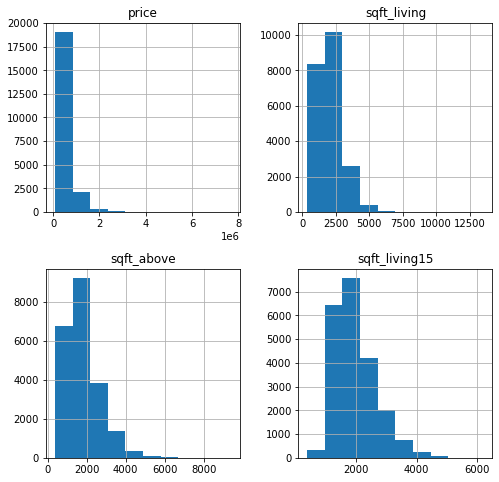

In [20]:
df2[['price', 'sqft_living', 'sqft_above', 'sqft_living15']].hist(figsize  = [8, 8]); 

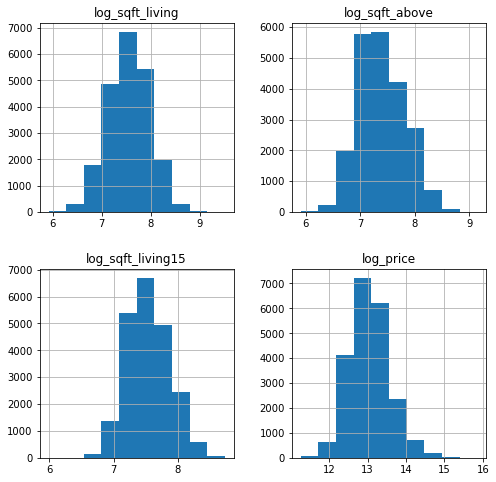

In [21]:
data_log = pd.DataFrame([])
data_log['log_sqft_living'] = np.log(df2['sqft_living'])
data_log['log_sqft_above'] = np.log(df2['sqft_above'])
data_log['log_sqft_living15'] = np.log(df2['sqft_living15'])
data_log['log_price'] = np.log(df2['price'])
data_log.hist(figsize  = [8, 8]);
#Create a function

In [22]:
formula = 'log_price ~ log_sqft_living + log_sqft_above + log_sqft_living15'
model = ols(formula=formula, data=data_log).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     6649.
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:27:35   Log-Likelihood:                -9727.0
No. Observations:               21597   AIC:                         1.946e+04
Df Residuals:                   21593   BIC:                         1.949e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.5408      0.060     92.919      0.000       5.424       5.658
log_sqft_living       0.6728      0.013     51.510      0.000       0.647       0.698
log_sqft_above       -0.0680      0.012     -5.529      0.000      -0.092      -0.044
log_sqft_living15     0.3887      0.012     32.091      0.000       0.365       0.412
==============================================================================
Omnibus:                      135.412   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.075
Skew:                           0.130   Prob(JB):                     2.29e-26
Kurtosis:                       2.748   Cond. No.                         303.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
data_log.corr()

,log_sqft_living,log_sqft_above,log_sqft_living15,log_price
log_sqft_living,1.000000,0.864979,0.746836,0.674802
log_sqft_above,0.864979,1.000000,0.713102,0.586013
log_sqft_living15,0.746836,0.713102,1.000000,0.607154
log_price,0.674802,0.586013,0.607154,1.000000


In [24]:
predictors = data_log.drop(['log_price'], axis=1)
predictors = predictors.corr().abs().stack().reset_index().sort_values(0, ascending=False)
predictors

,level_0,level_1,0
0,log_sqft_living,log_sqft_living,1.000000
4,log_sqft_above,log_sqft_above,1.000000
8,log_sqft_living15,log_sqft_living15,1.000000
1,log_sqft_living,log_sqft_above,0.864979
3,log_sqft_above,log_sqft_living,0.864979
2,log_sqft_living,log_sqft_living15,0.746836
6,log_sqft_living15,log_sqft_living,0.746836
5,log_sqft_above,log_sqft_living15,0.713102
7,log_sqft_living15,log_sqft_above,0.713102


In [25]:
predictors['pairs'] = list(zip(predictors.level_0, predictors.level_1))
predictors.set_index(['pairs'], inplace = True)
predictors.drop(columns=['level_1', 'level_0'], inplace = True)

,0
pairs,
"(log_sqft_living, log_sqft_living)",1.000000
"(log_sqft_above, log_sqft_above)",1.000000
"(log_sqft_living15, log_sqft_living15)",1.000000
"(log_sqft_living, log_sqft_above)",0.864979
"(log_sqft_above, log_sqft_living)",0.864979
"(log_sqft_living, log_sqft_living15)",0.746836
"(log_sqft_living15, log_sqft_living)",0.746836
"(log_sqft_above, log_sqft_living15)",0.713102
"(log_sqft_living15, log_sqft_above)",0.713102


In [26]:
predictors.columns = ['cc']

In [28]:
predictors.drop_duplicates(inplace=True)
predictors[(predictors.cc>.7) & (predictors.cc <1)]

,cc
pairs,
"(log_sqft_living, log_sqft_above)",0.864979
"(log_sqft_living, log_sqft_living15)",0.746836
"(log_sqft_above, log_sqft_living15)",0.713102


In [31]:
formula = 'log_price ~ log_sqft_living + log_sqft_above + log_sqft_living15'
model = ols(formula=formula, data=data_log).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     9028.
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:32:17   Log-Likelihood:                -10230.
No. Observations:               21597   AIC:                         2.047e+04
Df Residuals:                   21594   BIC:                         2.049e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7141      0.048    139.255      0.000       6.620       6.809
log_sqft_living     0.8277      0.012     66.629      0.000       0.803       0.852
log_sqft_above      0.0114      0.012      0.922      0.357      -0.013       0.036
==============================================================================
Omnibus:                      125.127   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.199
Skew:                           0.143   Prob(JB):                     9.66e-26
Kurtosis:                       2.785   Cond. No.                         195.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""